# Predictions for volume

In [1]:
from enveco.las import *
from enveco.image import *
from enveco.tabular import *

In [2]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback
import shap
shap.initjs()
from fastinference.tabular import *

# ANN

In [3]:
preprocessor = EnvecoPreprocessor('../enveco_data/enveco/AV.leaf.on.train.csv', 
                                  '../enveco_data/enveco/AV.leaf.on.val.csv',
                                  '../enveco_data/enveco/AV.leaf.on.test.csv')


Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features:
    * hmax: maximum height of the point cloud
    * hmean: mean height for vegetation pixels
    * hstd: standard deviation for vegetation pixels
    * cv: hstd / hmean
* point_features:
    * vege: proportion of vegetation points
    * ground: proportion of ground points
    * veg_ground_ratio: vege/ground
* intensity_features:
    * imax: maximum intensity for vegetation points
    * imean: mean intensity for vegetation points
    * imed: median intensity for vegetation points
* height_quantiles:
    * H where percentages of vegetation points (0%, 5%,...95%, 100%) were accumulated (e.g. h00, h05...h95, h100)
* point_proportions
    * Proportion of vegetation points having H greater or equal to corresponding percentile of H. H was divided to 10 equal distance fractions
 

In [ ]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col='h', path='../enveco_data/enveco/AV_las/', min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=False, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True,
                                                     log_y=False)

Adding height based features
Adding point distribution based features
Adding height quantiles


Put to dataloaders

In [77]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

In [78]:
test_tb.train.y.describe()

count    225.000000
mean      18.037333
std        5.210715
min        5.900000
25%       14.600000
50%       17.799999
75%       21.299999
max       36.200001
Name: d, dtype: float64

In [79]:
dls.show_batch()

,hmax,hmean,hstd,cv,veg,veg_ground_ratio,imax,imean,imedian,h00,h05,h10,h15,h20,h25,h30,h35,h40,h45,h50,h55,h60,h65,h70,h75,h80,h85,h90,h95,p00,p05,p10,p15,p20,p25,p30,p35,p40,p45,p50,p55,p60,p65,p70,p75,p80,p85,p90,p95,d
0,10.731000,7.505206,1.645810,0.219289,0.336406,110.006946,7.0,3.657534,4.0,3.593,5.02760,5.4042,5.87740,6.1468,6.28300,6.479600,6.77600,6.9778,7.24720,7.733,7.82300,7.9048,7.99480,8.1566,8.53000,9.034001,9.424600,9.586001,10.450400,1.0,0.945205,0.890411,0.849315,0.794521,0.753425,0.698630,0.643836,0.602740,0.547945,0.506849,0.452055,0.397260,0.356164,0.301370,0.260274,0.205479,0.150685,0.109589,0.054795,15.100000
1,16.264000,9.574607,3.227763,0.337117,0.446809,151.846161,7.0,3.785714,4.0,2.096,3.89835,4.5561,6.42315,7.0788,7.55150,8.086300,8.51300,8.9584,9.26600,9.666,10.03100,10.3526,10.57185,11.3967,11.58925,12.522600,12.963950,13.400500,15.045550,1.0,0.940476,0.892857,0.845238,0.797619,0.750000,0.702381,0.642857,0.595238,0.547619,0.500000,0.452381,0.404762,0.357143,0.297619,0.250000,0.202381,0.154762,0.107143,0.059524,15.700000
2,17.625000,10.345561,3.934995,0.380356,0.490000,192.156859,10.0,4.897959,5.0,1.608,2.71045,4.6500,5.98765,6.6930,7.54125,8.517000,9.18755,9.8280,10.46095,10.781,11.15935,12.0242,12.28105,12.6312,13.62675,13.820200,14.278500,15.076600,15.702949,1.0,0.948980,0.897959,0.846939,0.795918,0.744898,0.693878,0.653061,0.602041,0.551020,0.500000,0.448980,0.397959,0.346939,0.306122,0.255102,0.204082,0.153061,0.102041,0.051020,20.200001
3,17.577000,13.208293,2.908549,0.220206,0.451149,286.052365,6.0,3.375796,3.0,2.272,6.95620,9.7830,11.25420,11.5826,11.92400,12.318401,12.58100,13.1254,13.54780,13.678,13.99160,14.2232,14.57120,14.9150,15.19400,15.446400,15.678400,16.337000,16.907600,1.0,0.949045,0.898089,0.847134,0.796178,0.751592,0.700637,0.656051,0.598726,0.547771,0.503185,0.452229,0.401274,0.350318,0.299363,0.254777,0.203822,0.152866,0.101911,0.050955,17.100000
4,19.254000,9.997429,4.025244,0.402628,0.458755,585.687194,10.0,3.766562,4.0,1.528,2.43300,2.9380,3.68540,6.8482,8.55200,9.306200,9.73600,9.9710,10.19400,10.607,11.17160,11.5218,12.00680,12.1888,12.73100,13.294000,13.805800,14.144800,15.010400,1.0,0.949527,0.899054,0.848580,0.798107,0.750789,0.700315,0.649842,0.599369,0.552050,0.501577,0.451104,0.400631,0.350158,0.299685,0.252366,0.201893,0.151420,0.100946,0.050473,20.900000
5,20.976999,13.044572,4.022445,0.308362,0.727528,950.556712,10.0,3.532819,3.0,1.523,5.17070,6.1806,8.08030,10.0730,11.01900,11.962800,12.58520,12.9384,13.44740,13.863,14.22700,14.6414,15.08770,15.3666,15.67750,16.170000,16.828199,17.457399,18.369301,1.0,0.949807,0.899614,0.849421,0.799228,0.749035,0.698842,0.648649,0.598456,0.548263,0.501930,0.451737,0.401544,0.351351,0.301158,0.250965,0.200772,0.150579,0.100386,0.050193,18.100000
6,12.608000,5.695797,2.564716,0.450282,0.408840,125.177574,7.0,4.297297,4.0,1.577,2.14060,2.4672,2.97185,3.4118,3.60525,4.061200,4.49210,4.6822,4.95595,5.408,5.75775,6.3860,6.64650,6.7768,7.15050,7.662200,8.099400,9.061800,10.853249,1.0,0.945946,0.891892,0.851351,0.797297,0.743243,0.702703,0.648649,0.594595,0.554054,0.500000,0.445946,0.405405,0.351351,0.297297,0.256757,0.202703,0.148649,0.108108,0.054054,11.100000
7,14.892000,11.627603,2.168934,0.186533,0.497537,201.009807,8.0,3.831683,4.0,3.683,6.85100,9.3470,10.01100,10.3560,10.67000,10.970000,11.24900,11.4860,11.71600,11.886,11.98100,12.3080,12.56900,12.7160,13.03500,13.362000,13.806000,14.205000,14.445000,1.0,0.950495,0.900990,0.851485,0.801980,0.752475,0.702970,0.653465,0.603960,0.554455,0.504951,0.455446,0.405941,0.356436,0.306931,0.257426,0.207921,0.158416,0.108911,0.059406,16.900000
8,9.726000,5.398855,2.148257,0.397910,0.423469,143.964603,16.0,8.506024,9.0,1.526,1.95290,2.5902,2.98180,3.5002,3.73400,3.867000,4.28400,4.5354,5.10360,5.276,5.78800,6.1824,6.43320,6.9074,7.15700,7.383000,7.621700,8.023800,8.785000,1.0,0.939759,0.891566,0.843373,0.795181,0.746988,0.698795,0.650602,0.602410,0.554217,0.506024,0.445783,0.397590,0.349398

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias.

In [80]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,45))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 49'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 49              98         True      
________________________________________________________________
BatchNorm1d          64 x 49              98         True      
________________________________________________________________
Linear               64 x 200             9,800      True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0003981071640737355)

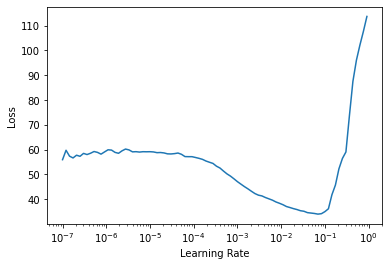

In [81]:
learn.lr_find()

1e-2 seems good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,50.306980,37.745644,6.143748,33.393162,4.344422,23.613272,5.233260,-0.175242,00:00
1,34.566723,12.178847,3.489821,18.968250,1.960504,10.655941,2.880175,0.620801,00:00
2,23.297537,8.461563,2.908877,15.810640,-0.793334,-4.312015,2.115393,0.736542,00:00
3,17.199924,7.824287,2.797193,15.203604,0.283628,1.541603,2.104204,0.756384,00:00
4,13.637192,6.863813,2.619888,14.239899,-0.435829,-2.368867,1.867576,0.786289,00:00
5,11.067090,6.900695,2.626917,14.278105,-0.086909,-0.472377,1.884593,0.785141,00:00
6,9.388847,6.844710,2.616240,14.220069,-0.293674,-1.596206,1.849632,0.786884,00:00
7,8.171457,6.644644,2.577721,14.010705,0.234858,1.276526,1.866490,0.793113,00:00
8,7.326811,8.195312,2.862746,15.559904,0.080798,0.439160,2.102933,0.744832,00:00
9,6.834329,6.727713,2.593783,14.098011,-0.048841,-0.265465,1.824869,0.790527,00:00


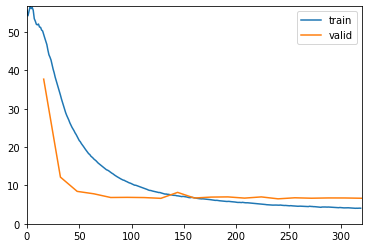

In [82]:
learn.fit_one_cycle(20, max_lr=1e-2, cbs=ShowGraphCallback())

See validation results

In [83]:
learn.validate()

(#7) [6.665788650512695,2.5818188190460205,14.032979011535645,-0.1910632997751236,-1.0384879112243652,1.7996582984924316,0.7924550893252399]

In [84]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

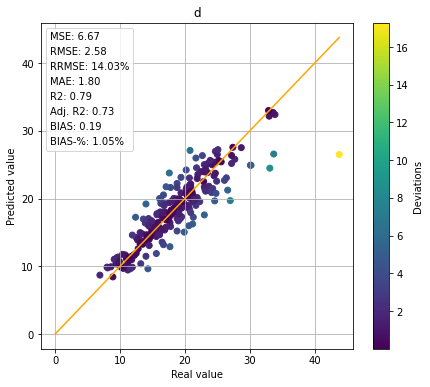

In [85]:
reg_interp.plot_results()
plt.show()

Evaluate test set.

In [86]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [87]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls)

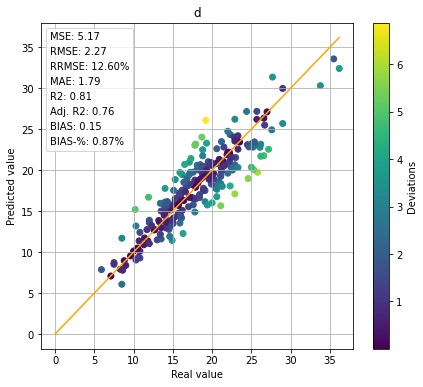

In [88]:
test_interp.plot_results()
plt.show()

In [89]:
preds, true = learn.get_preds()

## Use fastinference to get SHAP values

In [90]:
exp = ShapInterpretation(learn, n_samples=225)

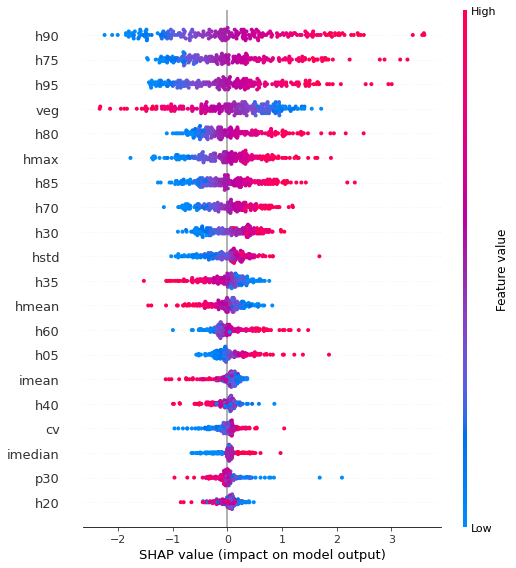

In [91]:
exp.summary_plot()

In [92]:
idx = np.random.randint(0,225,1)[0]

In [93]:
print(f'Correct value for row {idx} is {trainval_tb.valid.ys.iloc[idx].d:.2f}')
print(f'Predicted value for row {idx} is {learn.predict(trainval_tb.decode_row(trainval_tb.valid.xs.iloc[idx]))[2].item():.2f}')

Correct value for row 158 is 14.80


Predicted value for row 158 is 14.88


Displaying row 158 of 225 (use `row_idx` to specify another row)


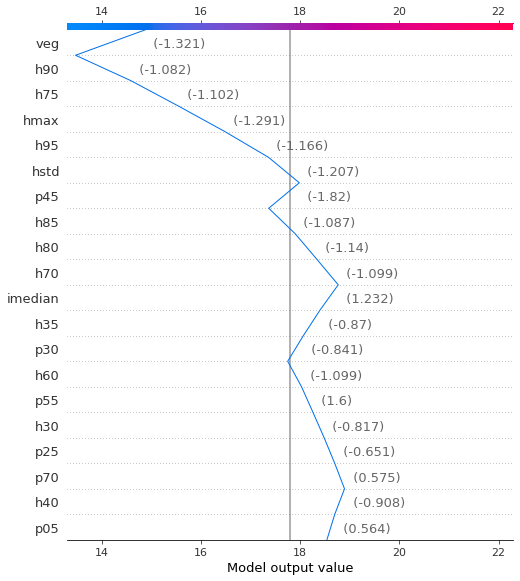

In [94]:
exp.decision_plot(row_idx=idx)

Displaying row 158 of 225 (use `row_idx` to specify another row)


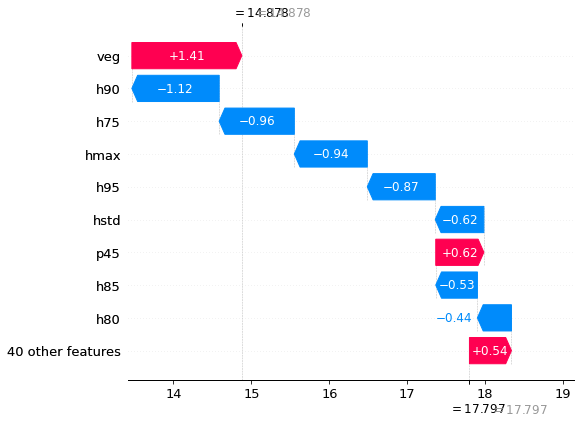

In [95]:
exp.waterfall_plot(row_idx=idx, max_display=10)

# Ensemble of ANNs

Fit several models at once

In [19]:
ensemble = ANNEnsemble(dls, 
                       y_range=(1,7), 
                       metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], n_models=10)

In [20]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.649246,0.625323,0.790774,16.478865,-0.551234,-11.487114,0.695321,-0.131599,00:00
1,0.432138,0.169972,0.412277,8.591404,-0.206095,-4.294803,0.336585,0.692414,00:00
2,0.291867,0.111173,0.333426,6.948236,0.077305,1.610949,0.251226,0.798819,00:00
3,0.216704,0.077695,0.278739,5.808620,-0.070865,-1.476753,0.204844,0.859400,00:00
4,0.165673,0.063110,0.251218,5.235108,0.004382,0.091323,0.177449,0.885794,00:00
5,0.130931,0.072659,0.269553,5.617184,0.010269,0.213987,0.190983,0.868515,00:00
6,0.106830,0.065325,0.255588,5.326168,-0.024457,-0.509658,0.183094,0.881786,00:00
7,0.088346,0.069982,0.264540,5.512737,0.032835,0.684246,0.189009,0.873360,00:00
8,0.076377,0.064787,0.254532,5.304172,-0.011631,-0.242373,0.181202,0.882761,00:00
9,0.067032,0.067710,0.260212,5.422531,0.003513,0.073206,0.184943,0.877470,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.720347,0.668083,0.817363,17.032963,-0.546911,-11.397024,0.705529,-0.208977,00:00
1,0.490923,0.169739,0.411994,8.585512,-0.192377,-4.008936,0.331381,0.692836,00:00
2,0.339006,0.123595,0.351560,7.326133,0.109344,2.278616,0.254196,0.776340,00:00
3,0.248209,0.082586,0.287377,5.988632,0.002372,0.049434,0.217322,0.850551,00:00
4,0.187492,0.082518,0.287259,5.986173,0.052685,1.097900,0.205913,0.850674,00:00
5,0.147802,0.076521,0.276625,5.764562,0.031968,0.666182,0.198283,0.861525,00:00
6,0.122882,0.063120,0.251236,5.235494,0.034389,0.716637,0.183644,0.885777,00:00
7,0.102037,0.069105,0.262878,5.478102,0.061560,1.282853,0.194100,0.874946,00:00
8,0.090319,0.070479,0.265479,5.532293,0.003188,0.066441,0.198855,0.872459,00:00
9,0.080961,0.062692,0.250383,5.217705,0.025081,0.522654,0.184456,0.886552,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,1.046612,0.906274,0.951984,19.838324,-0.705129,-14.694129,0.834973,-0.640015,00:00
1,0.716057,0.260137,0.510037,10.628610,-0.352496,-7.345625,0.434764,0.529250,00:00
2,0.465536,0.110277,0.332080,6.920197,0.096822,2.017674,0.230237,0.800439,00:00
3,0.324776,0.075530,0.274828,5.727111,0.001362,0.028380,0.210693,0.863319,00:00
4,0.240047,0.064009,0.252999,5.272232,0.038645,0.805328,0.178549,0.884168,00:00
5,0.182479,0.062179,0.249356,5.196316,0.001576,0.032851,0.179848,0.887480,00:00
6,0.146418,0.068604,0.261925,5.458224,0.052101,1.085733,0.185326,0.875852,00:00
7,0.117454,0.069294,0.263238,5.485598,0.000379,0.007897,0.191140,0.874603,00:00
8,0.097997,0.062483,0.249967,5.209036,-0.007030,-0.146499,0.177857,0.886929,00:00
9,0.084321,0.060705,0.246384,5.134377,-0.003265,-0.068037,0.177199,0.890147,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.792029,0.780121,0.883245,18.405863,-0.663467,-13.825924,0.793057,-0.411725,00:00
1,0.556102,0.228807,0.478338,9.968040,-0.246328,-5.133202,0.397371,0.585946,00:00
2,0.371604,0.099663,0.315695,6.578741,0.066809,1.392221,0.245153,0.819647,00:00
3,0.264359,0.076199,0.276042,5.752409,0.018087,0.376919,0.199439,0.862109,00:00
4,0.198172,0.064292,0.253558,5.283875,-0.033488,-0.697852,0.192823,0.883656,00:00
5,0.154696,0.063089,0.251175,5.234224,-0.003880,-0.080845,0.182241,0.885833,00:00
6,0.125732,0.063623,0.252235,5.256306,0.006309,0.131467,0.186582,0.884867,00:00
7,0.102993,0.058060,0.240956,5.021265,-0.007287,-0.151863,0.177932,0.894934,00:00
8,0.088093,0.063312,0.251618,5.243454,0.026786,0.558190,0.182626,0.885430,00:00
9,0.075548,0.061328,0.247645,5.160648,-0.006965,-0.145151,0.181740,0.889020,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.753107,0.629600,0.793473,16.535128,-0.560452,-11.679217,0.686198,-0.139339,00:00
1,0.512161,0.185936,0.431204,8.985814,-0.224439,-4.677056,0.361010,0.663525,00:00
2,0.346655,0.110702,0.332719,6.933504,0.091596,1.908756,0.241164,0.799671,00:00
3,0.245148,0.065500,0.255929,5.333281,-0.022894,-0.477081,0.187978,0.881470,00:00
4,0.183656,0.055775,0.236167,4.921468,0.006896,0.143715,0.170875,0.899068,00:00
5,0.143807,0.055973,0.236586,4.930196,-0.001762,-0.036724,0.171563,0.898710,00:00
6,0.116249,0.064618,0.254201,5.297280,0.022949,0.478228,0.187376,0.883065,00:00
7,0.097439,0.054462,0.233370,4.863177,-0.045112,-0.940084,0.167859,0.901445,00:00
8,0.082519,0.051708,0.227394,4.738638,0.039318,0.819335,0.163941,0.906428,00:00
9,0.070784,0.050531,0.224792,4.684415,0.009622,0.200518,0.162506,0.908557,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.972881,0.859737,0.927220,19.322266,-0.699686,-14.580688,0.818598,-0.555800,00:00
1,0.700384,0.263890,0.513702,10.704989,-0.375569,-7.826442,0.437045,0.522459,00:00
2,0.461459,0.100336,0.316758,6.600892,0.069809,1.454736,0.236849,0.818430,00:00
3,0.322119,0.066617,0.258102,5.378568,0.003687,0.076830,0.198416,0.879449,00:00
4,0.235910,0.056751,0.238225,4.964359,0.004446,0.092651,0.175265,0.897301,00:00
5,0.183334,0.058506,0.241881,5.040527,0.017035,0.354994,0.178999,0.894126,00:00
6,0.145375,0.058829,0.242548,5.054434,-0.004530,-0.094401,0.181080,0.893541,00:00
7,0.119376,0.057921,0.240668,5.015264,0.015219,0.317153,0.176175,0.895185,00:00
8,0.097837,0.051709,0.227397,4.738708,0.013886,0.289361,0.168254,0.906425,00:00
9,0.083934,0.056702,0.238122,4.962212,0.018911,0.394080,0.177460,0.897390,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,1.205498,0.929647,0.964182,20.092505,-0.838499,-17.473413,0.881047,-0.682310,00:00
1,0.893975,0.349653,0.591314,12.322351,-0.436280,-9.091612,0.507075,0.367260,00:00
2,0.576420,0.104177,0.322765,6.726070,0.046983,0.979085,0.238614,0.811479,00:00
3,0.397280,0.076298,0.276220,5.756132,0.024368,0.507810,0.205953,0.861930,00:00
4,0.293535,0.071743,0.267849,5.581685,0.009695,0.202036,0.197346,0.870172,00:00
5,0.220326,0.070235,0.265018,5.522696,-0.023432,-0.488298,0.198127,0.872902,00:00
6,0.171842,0.065114,0.255174,5.317552,-0.010763,-0.224295,0.189050,0.882169,00:00
7,0.136068,0.065086,0.255119,5.316407,0.013531,0.281971,0.183041,0.882219,00:00
8,0.112961,0.064946,0.254845,5.310697,-0.027161,-0.566003,0.187419,0.882472,00:00
9,0.093904,0.062655,0.250310,5.216195,0.019967,0.416100,0.183624,0.886618,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,1.489540,1.260826,1.122865,23.399296,-0.955715,-19.916071,1.013990,-1.281620,00:00
1,1.092621,0.433889,0.658703,13.726652,-0.547900,-11.417639,0.590284,0.214824,00:00
2,0.699420,0.135484,0.368081,7.670410,0.076165,1.587198,0.268467,0.754826,00:00
3,0.474161,0.092580,0.304269,6.340642,-0.018356,-0.382513,0.229630,0.832466,00:00
4,0.338219,0.080437,0.283615,5.910220,0.044332,0.923824,0.203697,0.854439,00:00
5,0.250918,0.068633,0.261979,5.459365,0.026585,0.554008,0.188859,0.875800,00:00
6,0.192413,0.063235,0.251466,5.240272,-0.006235,-0.129930,0.182761,0.885569,00:00
7,0.151354,0.073267,0.270679,5.640663,0.043708,0.910825,0.195877,0.867414,00:00
8,0.123825,0.071491,0.267377,5.571850,-0.004112,-0.085696,0.201164,0.870629,00:00
9,0.103667,0.064471,0.253911,5.291221,-0.021757,-0.453395,0.181338,0.883333,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,1.426690,1.112497,1.054750,21.979839,-0.883790,-18.417229,0.959965,-1.013199,00:00
1,1.023144,0.379193,0.615787,12.832330,-0.441348,-9.197220,0.537295,0.313803,00:00
2,0.671571,0.159280,0.399099,8.316788,0.072047,1.501378,0.283167,0.711763,00:00
3,0.459329,0.098434,0.313741,6.538026,0.024553,0.511667,0.237072,0.821872,00:00
4,0.328212,0.079639,0.282204,5.880825,0.003043,0.063405,0.205929,0.855883,00:00
5,0.246511,0.079751,0.282402,5.884944,0.015540,0.323842,0.204035,0.855681,00:00
6,0.190869,0.070769,0.266024,5.543653,-0.032042,-0.667716,0.192426,0.871935,00:00
7,0.152760,0.063489,0.251971,5.250802,0.022367,0.466099,0.179674,0.885108,00:00
8,0.127550,0.067624,0.260046,5.419079,0.038206,0.796168,0.184696,0.877626,00:00
9,0.104811,0.064293,0.253561,5.283942,-0.021597,-0.450065,0.181240,0.883653,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.641648,0.565535,0.752021,15.671301,-0.526261,-10.966714,0.658688,-0.023406,00:00
1,0.451394,0.181558,0.426096,8.879375,-0.192681,-4.015258,0.330929,0.671449,00:00
2,0.303503,0.097903,0.312894,6.520378,0.060762,1.266207,0.226755,0.822833,00:00
3,0.220463,0.073076,0.270326,5.633297,0.004431,0.092329,0.190479,0.867760,00:00
4,0.168886,0.072973,0.270136,5.629338,0.048506,1.010814,0.189439,0.867946,00:00
5,0.132965,0.071111,0.266667,5.557055,0.042072,0.876726,0.183506,0.871315,00:00
6,0.109401,0.067741,0.260271,5.423771,-0.059902,-1.248284,0.186362,0.877414,00:00
7,0.093082,0.066296,0.257480,5.365594,0.010034,0.209108,0.181652,0.880030,00:00
8,0.083528,0.078287,0.279798,5.830691,0.057420,1.196570,0.197189,0.858330,00:00
9,0.073470,0.071408,0.267222,5.568623,0.024074,0.501670,0.190686,0.870779,00:00


In [21]:
res = ensemble.validate()

In [22]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,0.224925,4.687203,0.006562,0.136749,0.160360,0.908449
1,0,0.246827,5.143610,0.007788,0.162300,0.176400,0.889751
2,1,0.250808,5.226558,0.013862,0.288870,0.182544,0.886167
3,2,0.239922,4.999716,-0.007399,-0.154193,0.169533,0.895833
4,3,0.238835,4.977064,0.020280,0.422606,0.175739,0.896775
5,4,0.227115,4.732826,0.004598,0.095822,0.160868,0.906658
6,5,0.229256,4.777438,0.001723,0.035916,0.168208,0.904890
7,6,0.242874,5.061234,-0.001890,-0.039384,0.177595,0.893254
8,7,0.252841,5.268932,0.004324,0.090103,0.177941,0.884313
9,8,0.242382,5.050987,0.007976,0.166206,0.175534,0.893686


In [23]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

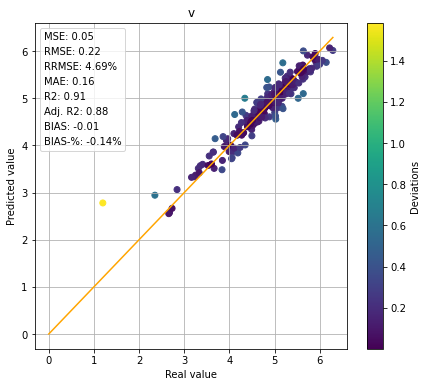

In [24]:
ens_int.plot_results()
plt.show()

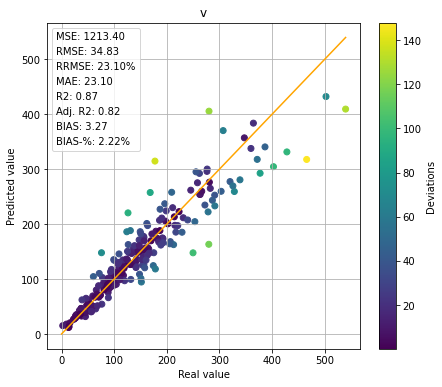

In [26]:
ens_int.plot_results(log_y=True)
plt.show()

In [27]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,0.204730,4.254948,-0.026400,-0.548671,0.151315,0.919352
1,0,0.222753,4.629529,-0.019554,-0.406389,0.168954,0.904528
2,1,0.225829,4.693457,-0.018420,-0.382820,0.170149,0.901873
3,2,0.214759,4.463378,-0.040132,-0.834064,0.166951,0.911258
4,3,0.222407,4.622334,-0.033246,-0.690956,0.168328,0.904824
5,4,0.218955,4.550582,-0.029760,-0.618511,0.166452,0.907756
6,5,0.218999,4.551511,-0.037271,-0.774609,0.164849,0.907719
7,6,0.227533,4.728873,-0.038350,-0.797028,0.171790,0.900386
8,7,0.236391,4.912967,-0.025432,-0.528552,0.176444,0.892480
9,8,0.227285,4.723723,-0.009074,-0.188586,0.167040,0.900603


In [28]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

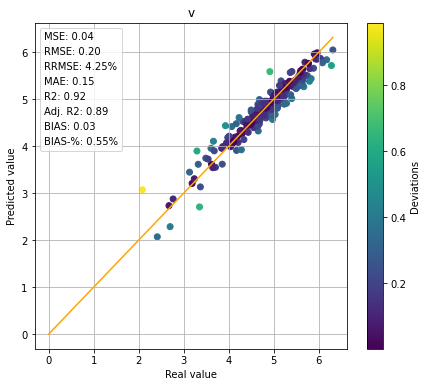

In [29]:
test_ens_interp.plot_results()
plt.show()

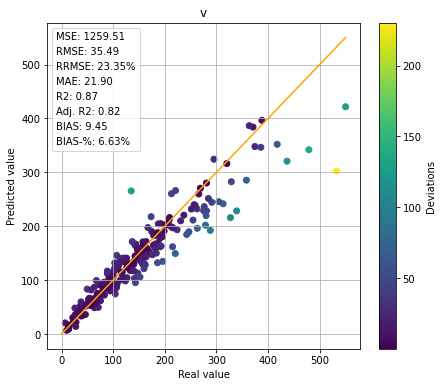

In [30]:
test_ens_interp.plot_results(log_y=True)
plt.show()

In [31]:
ensemble.predict(trainval_tb.decode_row(trainval_tb.valid.xs.iloc[0]))

(      hmax     hmean     hstd        cv       veg  veg_ground_ratio      imax  \
 0  2.96732  2.891253  2.43145  0.012076  1.906041          4.949219  1.453321   
 
       imean   imedian       h00  ...       d10       d20       d30       d40  \
 0  1.405186  1.232427 -0.684575  ... -0.780248 -0.780289 -0.541685 -0.751295   
 
         d50       d60       d70       d80       d90         v  
 0 -0.595009  0.858973  1.252316  0.614971  0.310631  6.021103  
 
 [1 rows x 60 columns],
 tensor([6.0166]),
 tensor([6.0166]))

In [32]:
model_res = [m.predict(trainval_tb.decode_row(trainval_tb.valid.xs.iloc[0])) for m in ensemble.models]

In [33]:
for res in model_res:
    print(res[-1])
sum([res[-1] for res in model_res]) / len(ensemble.models)

tensor([6.0211])
tensor([6.0656])
tensor([6.0957])
tensor([6.0161])
tensor([5.9893])
tensor([5.9660])
tensor([6.0149])
tensor([5.9587])
tensor([6.1111])
tensor([5.9273])


tensor([6.0166])

In [34]:
trainval_tb.valid.ys.iloc[0]

v    6.292458
Name: 0, dtype: float32

# Comparison: Random forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [7]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [8]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [9]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

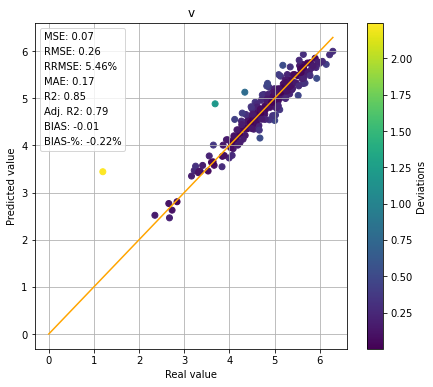

In [10]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

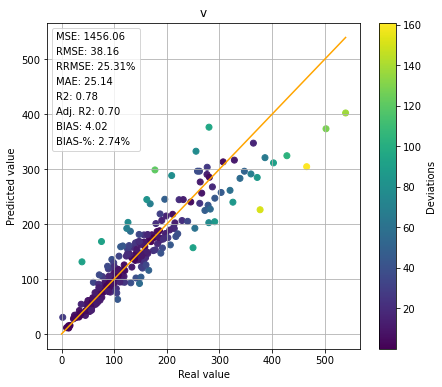

In [11]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=True)
plt.show()

Test

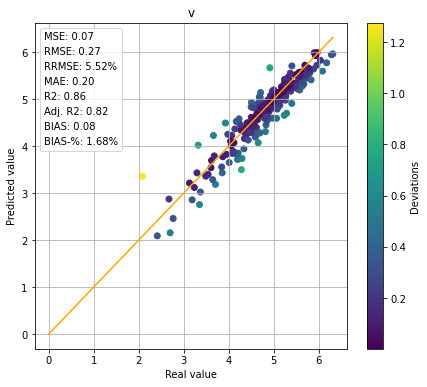

In [12]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()

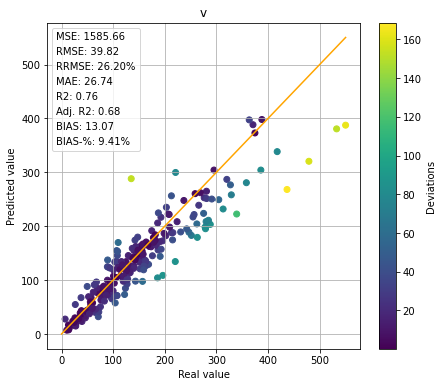

In [13]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()

## SHAP for RF

Todo comments and info.

In [56]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_tb.train.xs)

Get most influential features

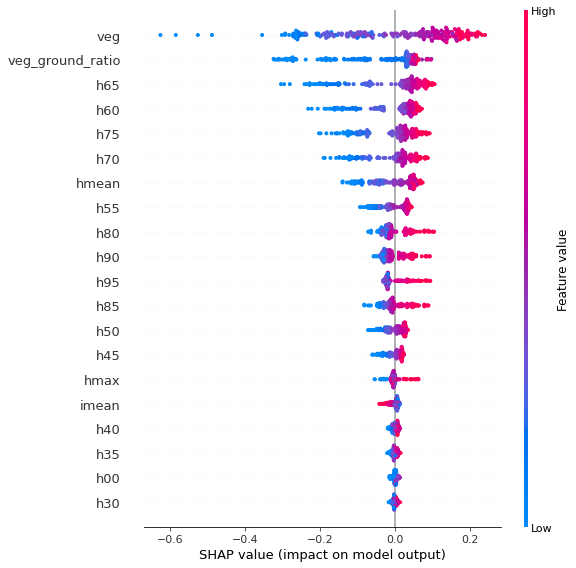

In [57]:
shap.summary_plot(shap_values, test_tb.train.xs)

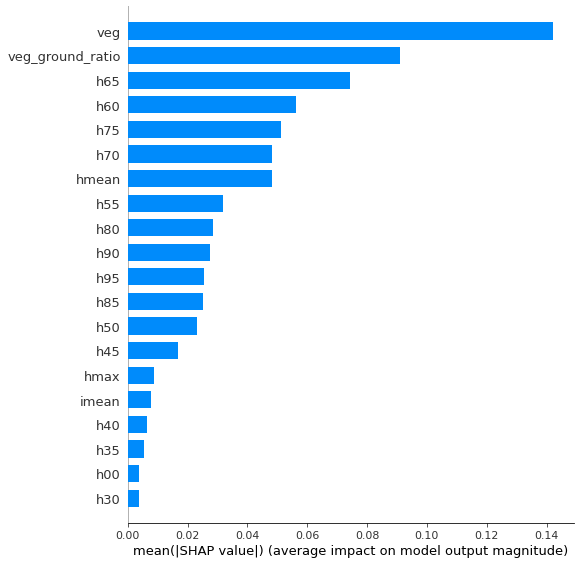

In [58]:
shap.summary_plot(shap_values, test_tb.train.xs, plot_type='bar')